In [1]:
import numpy as np
import sys
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import datetime
np.set_printoptions(threshold=sys.maxsize)
pd.options.display.max_rows=9999

Using TensorFlow backend.


In [2]:
datatype=7 # 0 for confirmed, 1 for death, 2 for recovered, 3 death county US
ipoprho=2 # this is specific to datatype=4, if = 1 then read in population density
#           data and make columns for that. Otherwise be sure to set to 0

if datatype == 7 or datatype == 8:
#    dataset1=read_csv('Hopkins_US_deaths_county_08112020.csv')
#    dataset1=read_csv('Coronavirus_case7_test.csv')
    dataset1=read_csv('Hopkins_US_deaths_county_08302020.csv')
    dataset2=read_csv('vote_2016_county.csv')
    dataset3=read_csv('State_Data/US_Governors_2019.csv')

dataset1.shape (3340, 233) dataset3.shape (50, 43) govs1.shape (50, 43)
govs1[4,6] democrat
dd1.shape (3256, 233)
dd1.shape (3142, 233)
dd1.shape (3142, 233) vote1.shape (3141, 11) dd1d.shape (3142, 221)
counts 0 fips 1000.0 state_list[counts] ['01000', 'ALABAMA']
counts 1 fips 2000.0 state_list[counts] ['02000', 'ALASKA']
counts 2 fips 4000.0 state_list[counts] ['04000', 'ARIZONA']
counts 3 fips 5000.0 state_list[counts] ['05000', 'ARKANSAS']
counts 4 fips 6000.0 state_list[counts] ['06000', 'CALIFORNIA']
counts 5 fips 8000.0 state_list[counts] ['08000', 'COLORADO']
counts 6 fips 9000.0 state_list[counts] ['09000', 'CONNECTICUT']
counts 7 fips 10000.0 state_list[counts] ['10000', 'DELAWARE']
counts 8 fips 11000.0 state_list[counts] ['11000', 'DISTRICT OF COLUMBIA']
counts 9 fips 12000.0 state_list[counts] ['12000', 'FLORIDA']
counts 10 fips 13000.0 state_list[counts] ['13000', 'GEORGIA']
counts 11 fips 15000.0 state_list[counts] ['15000', 'HAWAII']
counts 12 fips 16000.0 state_list[co

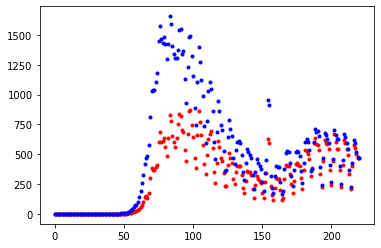

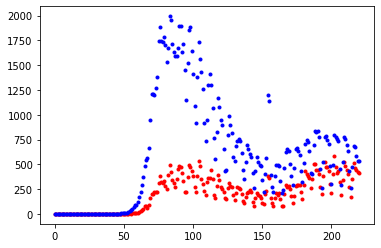

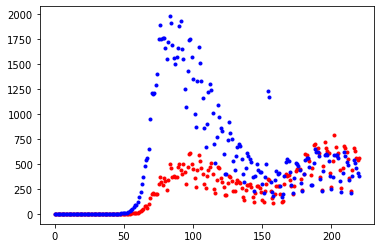

In [3]:
if datatype == 7:
    vote1=dataset2.to_numpy()
    govs1=dataset3.to_numpy()
    print('dataset1.shape',dataset1.shape,'dataset3.shape',dataset3.shape,'govs1.shape',govs1.shape)
    print('govs1[4,6]',govs1[4,6])
    dd1=dataset1.loc[dataset1['iso2']=='US']
    print('dd1.shape',dd1.shape)
    dd1=dd1.loc[dd1['FIPS']<56046] # Hopkins_US_deaths_county_08302020.csv in particular
#                                    has extraneous data, eg FIPS=90004 unassigned AZ
    print('dd1.shape',dd1.shape)
    dd1=dd1.to_numpy()
    dd1=dd1[dd1[:,4].argsort()]
    dd1d=dd1[:,12:] # this is the Hopkins data with only the death columns 1/22 onward
    print('dd1.shape',dd1.shape,'vote1.shape',vote1.shape,'dd1d.shape',dd1d.shape)
    vote2=vote1[vote1[:,10].argsort()] # sort table by county fips
    fipsv=vote2[:,10]
    fipsc=dd1[:,0].astype(int)-100000*np.trunc(dd1[:,0].astype(int)/100000.)
    fipsc2=dd1[:,4]
    vdemsr=vote2[:,4]
    dd2cols=dd1.shape[1]
#
#    for ii in range (dd1.shape[0]):
#        print('ii',ii,'fipsc[ii]',fipsc[ii],'fipsc2[ii]',fipsc2[ii])

# create a comma-separated list of states and counties and their fips codes
    file1=open('County_data/FIPS_county.txt','r')
    counts=0
    countc=0
    ncount=3145 # number of counties in FIPS_county.txt - verified in countc loop below
    state_list=[['' for i in range (2)] for j in range(51)]
    county_list=[['' for i in range (2)] for j in range(ncount)]

# get list of states and counties from FIPS_county.txt
    while True:
        line = file1.readline() # this is a different way to read files, perhaps useful
        if len(line) == 0:
            break
        fips = float(line[0:5])
        state_f=int(fips/1000)
        if int(line[0:5]) != 0: # all zeros is USA
            d1=int(fips-state_f*1000)
            if d1 == 0: # in addition to county lines, there are lines for each state
# and the 1st line is just USA
                state_list[counts][0]=line[0:5]
                state_list[counts][1]=line[6:len(line)-1]
                print('counts',counts,'fips',fips,'state_list[counts]',state_list[counts])
                counts+=1

            else:
                county_list[countc][0]=line[0:5]
                county_list[countc][1]=line[6:len(line)-1]
                countc+=1
                
    FIPS=np.array(county_list)[:,0].astype(int)

    print('counts',counts,'countc',countc,'FIPS.shape',FIPS.shape)

# governor data
    jj=0
    gg=np.zeros((51,2))
    state_list_np=np.asarray(state_list)
    for ii in range(counts):
        if state_list[ii][1]=='DISTRICT OF COLUMBIA':
            gg[ii,0]=state_list_np[ii][0]
            gg[ii,1]=0.5
        elif govs1[jj,6] == 'republican':
            gg[ii,0]=state_list_np[ii][0]
            gg[ii,1]=1.0
            jj+=1
        else:
            gg[ii,0]=state_list_np[ii][0]
            gg[ii,1]=0.0
            jj+=1
            
#        print('ii',ii,'jj',jj,'state_list[ii][1]',state_list[ii][1],'govs1[jj-1,6]',govs1[jj-1,6], \
#             'gg[ii,0]',gg[ii,0],gg[ii,1])

    arr11=gg[:,0].tolist()
    arr22=gg[:,1].tolist()
    d=dict(zip(arr11,arr22))
    print('d',d,'d(4000.0)',d[5000.0])
        #print('county_list',county_list)
#print('county_list',county_list[2][0])
    countc=countc
    counts=counts
    jj=0
    kk=0
    dline0=np.zeros(dd2cols-12) # 12 columns of non-death data
    print('dline0.shape',dline0.shape)
    lineout=np.zeros(dd2cols-12+2) # 0th and 1st elements are FIPS and vote
    Data1=np.zeros((countc,dd2cols-12+2))
    arr1=np.setdiff1d(FIPS,fipsc)
    arr1b=np.setdiff1d(fipsc,FIPS)
    arr2=np.setdiff1d(FIPS,fipsv)
    arr2b=np.setdiff1d(fipsv,FIPS)
    print('arr1',arr1,'\n arr1b',arr1b,'\n arr2',arr2,'\n arr2b',arr2b)
    for ii in range(countc):
        if np.isin(FIPS[ii],arr1):
            print('skip','ii',ii,'FIPS',FIPS[ii],'fipsc[jj]',fipsc[jj])
            dline=dline0
        else:
            dline=dd1d[jj]
            jj+=1

        if np.isin(FIPS[ii],arr2):
            print('skip','ii',ii,'FIPS',FIPS[ii],'fipsv[kk]',fipsv[kk])
            vote=0
        else:
            vote=vote2[kk,5]
            kk+=1

#        print('FIPS',FIPS[ii],'vote',vote)
        lineout[0]=FIPS[ii]
        lineout[1]=vote
        lineout[2:]=dline
        
        Data1[ii,:]=lineout
#        print('ii',ii,'FIPS',FIPS[ii],'jj-1',jj-1,'fipsc[jj-1]',fipsc[jj-1],'vote',vote,'deaths',lineout[-1])
        if FIPS[ii] != fipsc[jj-1]:
            print('FIPS[ii]',FIPS[ii],'fipsc[jj-1]',fipsc[jj-1])
#            wait=input('holding')

#        if fipsc[ii] != FIPS[ii]:
#            dline=dline0
            
#            print(ii,'FIPS',FIPS[ii],'fipsc',fipsc[ii],'fipsv',fipsv[ii])
#    print('Data1',Data1[:2,:])
    FIPSr=FIPS.astype(np.float)
#    print('FIPSr',FIPSr)
    Rdeaths=np.zeros((countc,dd2cols-12))
    Ddeaths=np.zeros((countc,dd2cols-12))
    RdeathsB=np.zeros((countc,dd2cols-12))
    DdeathsB=np.zeros((countc,dd2cols-12))
    RdeathsC=np.zeros((countc,dd2cols-12))
    DdeathsC=np.zeros((countc,dd2cols-12))
    Control=np.rint(Data1[:,1])
    for ii in range (countc):
        Rdeaths[ii,:]=Data1[ii,1]*Data1[ii,2:]
        Ddeaths[ii,:]=(1.0-Data1[ii,1])*Data1[ii,2:]
        RdeathsB[ii,:]=Control[ii]*Data1[ii,2:]
        DdeathsB[ii,:]=(1.0-Control[ii])*Data1[ii,2:]
        stateA=1000.0*int(FIPSr[ii]/1000)
        Control2=(Control[ii]+d[stateA])*0.5
        RdeathsC[ii,:]=Control2*Data1[ii,2:]
        DdeathsC[ii,:]=(1.0-Control2)*Data1[ii,2:]
#        print('ii',ii,'Rdeaths',Rdeaths[ii,-1],'Ddeaths',Ddeaths[ii,-1],'stateA',stateA,Data1[ii,0], \
#             'd[stateA]',d[stateA],Control2,'RdeathsC[ii,-1]',RdeathsC[ii,-1],'DdeathsC[ii,-1]',DdeathsC[ii,-1])

    Rdeaths_total=np.sum(Rdeaths,axis=0)
    Ddeaths_total=np.sum(Ddeaths,axis=0)
    print('Rdeaths_total[-1]',Rdeaths_total[-1])
    print('Ddeaths_total[-1]',Ddeaths_total[-1])
    Rdday=np.gradient(Rdeaths_total)
    Ddday=np.gradient(Ddeaths_total)
    Rdeaths_totalB=np.sum(RdeathsB,axis=0)
    Ddeaths_totalB=np.sum(DdeathsB,axis=0)
    print('Rdeaths_totalB[-1]',Rdeaths_totalB[-1])
    print('Ddeaths_totalB[-1]',Ddeaths_totalB[-1])
    RddayB=np.gradient(Rdeaths_totalB)
    DddayB=np.gradient(Ddeaths_totalB)
    Rdeaths_totalC=np.sum(RdeathsC,axis=0)
    Ddeaths_totalC=np.sum(DdeathsC,axis=0)
    print('Rdeaths_totalC[-1]',Rdeaths_totalC[-1])
    print('Ddeaths_totalC[-1]',Ddeaths_totalC[-1])
    RddayC=np.gradient(Rdeaths_totalC)
    DddayC=np.gradient(Ddeaths_totalC)
    f1=pyplot.figure()
    pyplot.plot(Rdday,'.r',Ddday,'.b')
    pyplot.show()
    f2=pyplot.figure()
    pyplot.plot(RddayB,'.r',DddayB,'.b')
    pyplot.show()
    f2=pyplot.figure()
    pyplot.plot(RddayC,'.r',DddayC,'.b')
    pyplot.show()